### **檔案說明**
* 此ipynb檔案旨在：在自己的資料集上訓練，在別人的資料集做測試

* `20240611_eric_2.xls`與`20240611_eric_2.csv`分別是IMU的轉換前和轉換後的檔案

* `20240611_ECU_eric.txt`與`20240611_ECU_eric.csv`分別是ECU的原始txt檔與解碼後的csv檔

* `20240611_Eric_merged.csv`為ECU與IMU合併後的csv檔

* `20240611_eric_2_only_mark.csv`與`20240611_kino_only_mark.csv`為IMU與ECU合併之後，校正之前，長度因此縮短的標記column單獨存檔(我用Excel來製作)，一個用於訓練，一個用於測試

* `20240611_Eric_model.pkl`為資料分群後的群中心模型

* `Ridetrack_Eric_v1.py`為函數呼叫的主要程式檔案

* `20240611_Eric_clustered.csv`為用訓練好的群中心模型去預測數據的駕駛行為

### **一、導入函式庫**

In [5]:
# 載入要使用的函式庫
import pandas as pd
import Ridetrack_Eric_v1
SensorFusion = Ridetrack_Eric_v1.SensorFusion()
AutoTag = Ridetrack_Eric_v1.AutoTag()
DrivePSTs = Ridetrack_Eric_v1.DrivePSTs()
else_ = Ridetrack_Eric_v1.else_()

### **二、定義訓練資料的路徑**

In [13]:
# 這裡修改個人的IMU與ECU的資料路徑 (不需要副檔名)
train_imu_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_eric_2'
train_ecu_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_ECU_eric'

test_imu_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_kino'
test_ecu_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_ECU_kino'

train_label_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_eric_2_only_mark'
test_label_file = r'C:\Users\eric\Desktop\KDD_Lab\機車行為辨識\20230913交接\motor_熊御仲\20240611_data\20240611_kino_only_mark'

train_name_file = '20240611_Eric_train'  # 命名用
test_name_file = '20240611_kino_test'  # 命名用

# 一開始閒置的時間(merge完後的檔案：開始幾筆snapshot是Idle)(校正角速度用)
k = 150

### **三、進行資料合併與訓練模型**

In [14]:
# Process training data
SensorFusion.Axis_Process(f'{train_imu_file}.xls', f'{train_imu_file}.csv', app_time_error=4)
SensorFusion.ECU_Reverse(f'{train_ecu_file}.txt', f'{train_ecu_file}.csv')
SensorFusion.Data_Merge(f'{train_ecu_file}.csv', f'{train_imu_file}.csv',  f'{train_name_file}_merged.csv')

df = pd.read_csv(f'{train_name_file}_merged.csv')
SensorFusion.calibrate_angles(df, f'{train_name_file}_merged.csv')

df = pd.read_csv(f'{train_name_file}_merged.csv')
SensorFusion.calibrate_imu(df, k, f'{train_name_file}_merged.csv')

feature = ['Atmospheric Pressure', 'Inclination Switch',
       'Fault Code Count', 'Ignition Coil Current Diagnosis',
       'Fault Light Mileage',
       'Ignition Advance Angle', 'Idling Correction Ignition Angle',
       'Fuel Injection Prohibition Mode', 'Injection Mode',
       'Bypass Delay Correction', 'ABV Opening', 'ABV Idling Correction',
       'Lambda Setting', 'Air-Fuel Ratio Rich',
       'Closed Loop Control', 'Air Flow', 'Throttle Valve Air Flow',
       'Intake Manifold Pressure', 'Intake Manifold Front Pressure',
       'MFF_AD_ADD_MMV_REL', 'MFF_AD_FAC_MMV_REL', 'MFF_AD_ADD_MMV',
       'MFF_AD_FAC_MMV', 'Fuel Injection Quantity', 'MFF_WUP_COR',
       'Ignition Mode', 'Engine RPM', 'Engine RPM Limit', 'Idling Target RPM',
       'Fuel Injection Start Angle', 'Fuel Pump State', 'Engine State',
       'Engine Temperature', 'Water Temperature PWM',
       'Ignition Magnetization Time', 'Fuel Injection Time',
       'Closed Loop Fuel Correction', 'Intake Temperature',
       'Combustion Chamber Intake Temperature', 'TPS Opening',
       'TPS Idling Learning Value', 'Battery Voltage', 'O2 Voltage',
       'Vehicle Speed', 'TPS Voltage', 
       'X-axis Angular Velocity', 'Y-axis Angular Velocity',
       'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration',
       'Z-axis Acceleration', 'Pitch (deg)', 'Roll (deg)', 'Yaw (deg)']

df = pd.read_csv(f'{train_name_file}_merged.csv')
SensorFusion.apply_kalman_filter(df, feature,  q_noise=0.0001, r_noise=0.001, save_path=f'{train_name_file}_merged.csv')

df = pd.read_csv(f'{train_name_file}_merged.csv')

#feature = ['Z-axis Angular Velocity', 'Yaw (deg)', 'Y-axis Acceleration', 'Z-axis Acceleration',
#           'Pitch (deg)', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Roll (deg)']
feature = ['Z-axis Angular Velocity', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration']

# 利用k-means進行分群以得到群中心模型
AutoTag.cluster_data(df, feature, method="kmeans", n_clusters=11, model_path=f'{train_name_file}_model.pkl', save_path=f'{train_name_file}_merged.csv')

df_train = pd.read_csv(f'{train_name_file}_merged.csv')
train_label = pd.read_csv(f'{train_label_file}.csv', skip_blank_lines=False)  # skip_blank_lines=False 要把空白值算入
df_train['Action'] = train_label['Action']

Execution time: 0.0 hours 0.0 minutes 4.495833873748779 seconds

【Reverse Engineering Restores ECU Data Part 1 (1/2)】


100%|██████████| 2930/2930 [00:19<00:00, 154.00it/s]



【Reverse Engineering Restores ECU Data Part 2 (2/2)】


100%|██████████| 2930/2930 [00:18<00:00, 154.87it/s]


Execution time: 0.0 hours 0.0 minutes 38.09092092514038 seconds

【Data Engineering Megre Data Part 1 (1/2)】


100%|██████████| 2929/2929 [00:04<00:00, 609.08it/s]



【Data Engineering Megre Data Part 2 (2/2)】


100%|██████████| 2929/2929 [00:09<00:00, 317.61it/s]


Execution time: 0.0 hours 0.0 minutes 22.35280132293701 seconds


100%|██████████| 29149/29149 [00:00<00:00, 265701.24it/s]


Execution time: 0.0 hours 0.0 minutes 1.3131556510925293 seconds
Execution time: 0.0 hours 0.0 minutes 1.2701597213745117 seconds


100%|██████████| 29149/29149 [00:34<00:00, 848.96it/s] 


Execution time: 0.0 hours 0.0 minutes 36.27433371543884 seconds
Execution time: 0.0 hours 0.0 minutes 2.6165666580200195 seconds


In [15]:
# Process testing data
SensorFusion.Axis_Process(f'{test_imu_file}.xls', f'{test_imu_file}.csv', app_time_error=4)
SensorFusion.ECU_Reverse(f'{test_ecu_file}.txt', f'{test_ecu_file}.csv')
SensorFusion.Data_Merge(f'{test_ecu_file}.csv', f'{test_imu_file}.csv',  f'{test_name_file}_merged.csv')

df = pd.read_csv(f'{test_name_file}_merged.csv')
SensorFusion.calibrate_angles(df, f'{test_name_file}_merged.csv')

df = pd.read_csv(f'{test_name_file}_merged.csv')
SensorFusion.calibrate_imu(df, k, f'{test_name_file}_merged.csv')

feature = ['Atmospheric Pressure', 'Inclination Switch',
       'Fault Code Count', 'Ignition Coil Current Diagnosis',
       'Fault Light Mileage',
       'Ignition Advance Angle', 'Idling Correction Ignition Angle',
       'Fuel Injection Prohibition Mode', 'Injection Mode',
       'Bypass Delay Correction', 'ABV Opening', 'ABV Idling Correction',
       'Lambda Setting', 'Air-Fuel Ratio Rich',
       'Closed Loop Control', 'Air Flow', 'Throttle Valve Air Flow',
       'Intake Manifold Pressure', 'Intake Manifold Front Pressure',
       'MFF_AD_ADD_MMV_REL', 'MFF_AD_FAC_MMV_REL', 'MFF_AD_ADD_MMV',
       'MFF_AD_FAC_MMV', 'Fuel Injection Quantity', 'MFF_WUP_COR',
       'Ignition Mode', 'Engine RPM', 'Engine RPM Limit', 'Idling Target RPM',
       'Fuel Injection Start Angle', 'Fuel Pump State', 'Engine State',
       'Engine Temperature', 'Water Temperature PWM',
       'Ignition Magnetization Time', 'Fuel Injection Time',
       'Closed Loop Fuel Correction', 'Intake Temperature',
       'Combustion Chamber Intake Temperature', 'TPS Opening',
       'TPS Idling Learning Value', 'Battery Voltage', 'O2 Voltage',
       'Vehicle Speed', 'TPS Voltage', 
       'X-axis Angular Velocity', 'Y-axis Angular Velocity',
       'Z-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Acceleration',
       'Z-axis Acceleration', 'Pitch (deg)', 'Roll (deg)', 'Yaw (deg)']

df = pd.read_csv(f'{test_name_file}_merged.csv')
SensorFusion.apply_kalman_filter(df, feature,  q_noise=0.0001, r_noise=0.001, save_path=f'{test_name_file}_merged.csv')

df = pd.read_csv(f'{test_name_file}_merged.csv')

#feature = ['Z-axis Angular Velocity', 'Yaw (deg)', 'Y-axis Acceleration', 'Z-axis Acceleration',
#           'Pitch (deg)', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Roll (deg)']
feature = ['Z-axis Angular Velocity', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration']

# 利用k-means進行分群以得到群中心模型
# AutoTag.cluster_data(df, feature, method="kmeans", n_clusters=11, model_path=f'{train_name_file}_model.pkl', save_path=f'{train_name_file}_merged.csv')

df_test = pd.read_csv(f'{test_name_file}_merged.csv')
test_label = pd.read_csv(f'{test_label_file}.csv', skip_blank_lines=False)  # skip_blank_lines=False 要把空白值算入
df_test['Action'] = test_label['Action']

Execution time: 0.0 hours 0.0 minutes 6.815922260284424 seconds

【Reverse Engineering Restores ECU Data Part 1 (1/2)】


100%|██████████| 3482/3482 [00:23<00:00, 146.50it/s]



【Reverse Engineering Restores ECU Data Part 2 (2/2)】


100%|██████████| 3482/3482 [00:23<00:00, 147.69it/s]


Execution time: 0.0 hours 0.0 minutes 47.52174997329712 seconds

【Data Engineering Megre Data Part 1 (1/2)】


100%|██████████| 3481/3481 [00:07<00:00, 439.64it/s]



【Data Engineering Megre Data Part 2 (2/2)】


100%|██████████| 3481/3481 [00:15<00:00, 229.64it/s]


Execution time: 0.0 hours 0.0 minutes 34.822564125061035 seconds


100%|██████████| 41124/41124 [00:00<00:00, 277659.55it/s]


Execution time: 0.0 hours 0.0 minutes 1.8407611846923828 seconds
Execution time: 0.0 hours 0.0 minutes 1.7523422241210938 seconds


100%|██████████| 41124/41124 [00:50<00:00, 814.37it/s] 


Execution time: 0.0 hours 0.0 minutes 53.1911985874176 seconds


In [20]:
feature = ['Z-axis Angular Velocity', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration']

Execution time: 0.0 hours 0.0 minutes 2.5257537364959717 seconds


100%|██████████| 41124/41124 [04:37<00:00, 148.24it/s]


Execution time: 0.0 hours 4.0 minutes 43.87071990966797 seconds
            index  Go Straight  Turn Left    U-turn  Turn Right       Idle  \
0         Predict    28.194660  30.578512  4.735758   35.669707  28.092899   
1  Filter_Predict    30.165658  31.168831  4.667124   40.134422  28.308769   

   Two-Stage Left  Accuracy (Total)  
0        7.575758         27.600650  
1        6.439394         28.979032  
| Action         |   Predicted: Go Straight |   Predicted: Idle |   Predicted: Turn Left |   Predicted: Turn Right |   Predicted: Two-Stage Left |   Predicted: U-turn |   Accuracy |
|:---------------|-------------------------:|------------------:|-----------------------:|------------------------:|----------------------------:|--------------------:|-----------:|
| Go Straight    |                     6008 |              1567 |                   5436 |                    4157 |                        1385 |                2756 |   28.1947  |
| Idle           |                     31

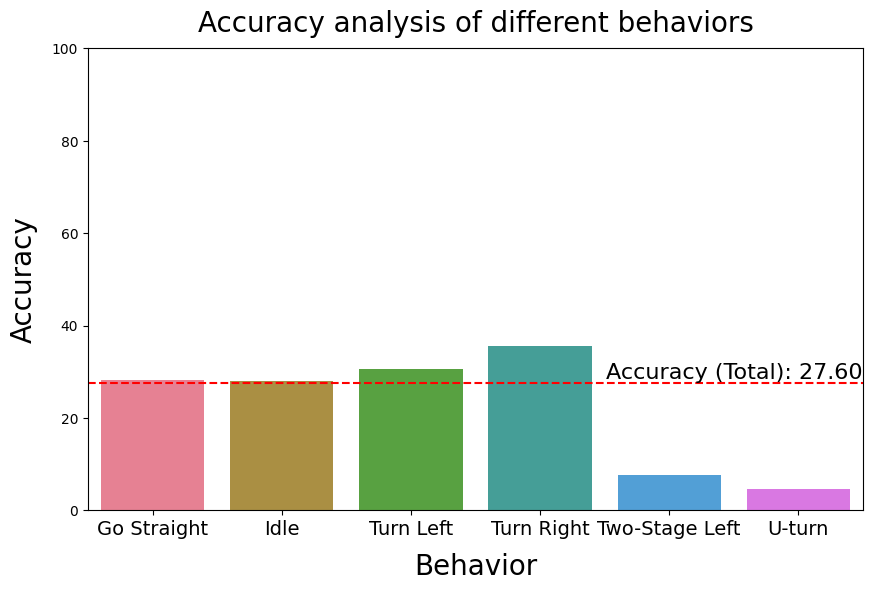

完整的Go Straight行為有36個
完整的Turn Left行為有7個
完整的U-turn行為有8個
完整的Turn Right行為有10個
完整的Idle行為有20個
完整的Two-Stage Left行為有1個


In [21]:
# DrivePSTs.train_vomm(df_train, 30, 11, False)
AutoTag.predict_cluster(df_test, feature, '20240611_data/20240612noangle_merged/20240612noangle_model.pkl', f'{test_name_file}_merged.csv')
Test_Data = DrivePSTs.test_vomm(df_test, 6, save_path=f'{test_name_file}_merged.csv')

Test_Data = Test_Data.dropna()

print(DrivePSTs.compute_accuracy(Test_Data, 6, None))
DrivePSTs.calculate_action_prediction_counts(Test_Data['Action'], Test_Data['Predict'], True)

# 計算每個完整動作的數量
df = pd.read_csv(f'{test_name_file}_merged.csv', skip_blank_lines=False)

# 初始化變數
last_action = None
action_counts = {}

# 遍歷每一行
for action in df['Action']:
    # 如果當前行為與上一個行為不同，則開始新的行為
    if action != last_action:
        if (action not in action_counts) and (str(action) != 'nan'):
            action_counts[action] = 0
        
        if str(action) != 'nan':
            action_counts[action] += 1
            
    last_action = action

# 輸出結果
for action, count in action_counts.items():
    print(f'完整的{action}行為有{count}個')

### **四、繪製資料點3D散佈圖**

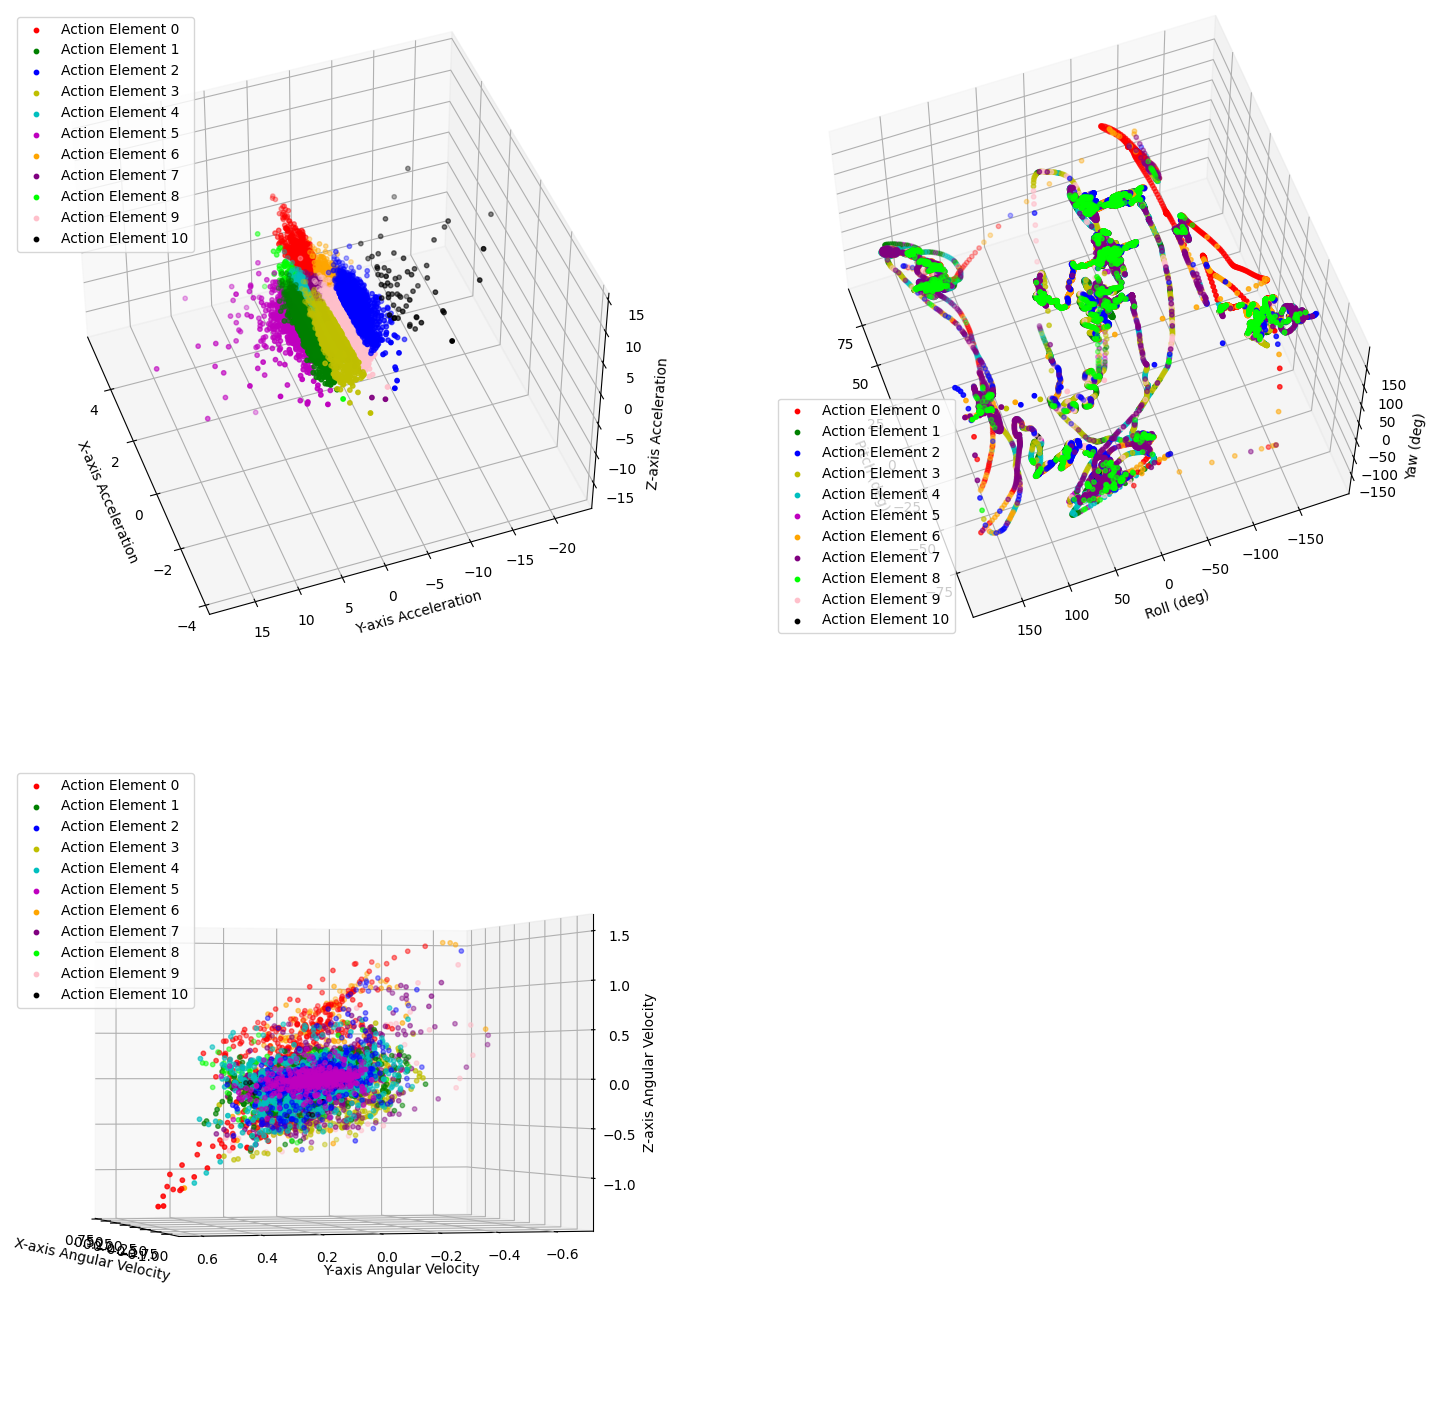

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load the provided CSV file
file_path = '20240611_Eric_merged.csv'
data = pd.read_csv(file_path)

# Set up the 3D plot
fig = plt.figure(figsize=(18, 18))
ax = fig.add_subplot(221, projection='3d')
bx = fig.add_subplot(222, projection='3d')
cx = fig.add_subplot(223, projection='3d')

# Group data by 'Action Element' for color coding
groups = data.groupby('Action Element')

# Colors for each 'Action Element'
# colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink', 'k', 'grey']
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink', 'k']
# colors = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'lime', 'pink']

# count = 0  # 為了畫2個群組而已
for (key, group), color in zip(groups, colors):
    ax.scatter(group['X-axis Acceleration'], group['Y-axis Acceleration'], group['Z-axis Acceleration'], c=color, label=f'Action Element {key}', s=10)
    # count += 1
    # if count >= 2:
    #     break

ax.set_xlabel('X-axis Acceleration')
ax.set_ylabel('Y-axis Acceleration')
ax.set_zlabel('Z-axis Acceleration')

for (key, group), color in zip(groups, colors):
    bx.scatter(group['Pitch (deg)'], group['Roll (deg)'], group['Yaw (deg)'], c=color, label=f'Action Element {key}', s=10)

bx.set_xlabel('Pitch (deg)')
bx.set_ylabel('Roll (deg)')
bx.set_zlabel('Yaw (deg)')

# count = 0  # 為了畫2個群組而已
for (key, group), color in zip(groups, colors):
    cx.scatter(group['X-axis Angular Velocity'], group['Y-axis Angular Velocity'], group['Z-axis Angular Velocity'], c=color, label=f'Action Element {key}', s=10)
    # count += 1
    # if count >= 2:
    #     break

cx.set_xlabel('X-axis Angular Velocity')
cx.set_ylabel('Y-axis Angular Velocity')
cx.set_zlabel('Z-axis Angular Velocity')

# Legend
ax.view_init(elev=45, azim=160)  # elev=45, azim=160
bx.view_init(elev=60, azim=160)
cx.view_init(elev=0, azim=165)

ax.legend()
bx.legend()
cx.legend()

plt.show()

### **五、繪製駕駛行為軌跡**

In [ ]:
import Ridetrack
else_ = Ridetrack.else_()

feature = ['Z-axis Angular Velocity', 'Z-axis Angle', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'X-axis Angle', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Y-axis Angle']

df = pd.read_csv(f'{name_file}_merged.csv')

AutoTag.predict_cluster(df, feature, '20240125_Eric_model.pkl', f'{name_file}_clustered.csv')

df_clustered = pd.read_csv(f'{name_file}_clustered.csv')

else_.Plot_Action_Track(df_clustered, 'Filter_Predict', 250, False)

Execution time: 0.0 hours 0.0 minutes 3.4757540225982666 seconds


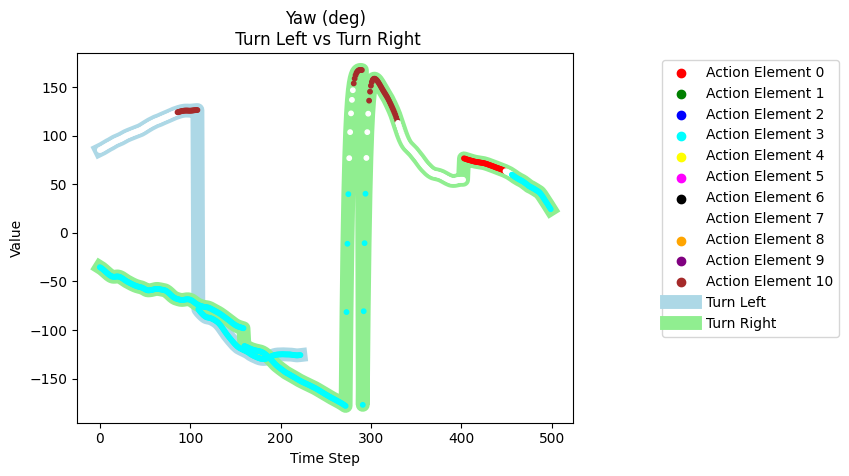

In [13]:
feature = ['Z-axis Angular Velocity', 'Yaw (deg)', 'Y-axis Acceleration', 'Z-axis Acceleration',
           'Pitch (deg)', 'X-axis Angular Velocity', 'Y-axis Angular Velocity', 'X-axis Acceleration', 'Roll (deg)']

df = pd.read_csv(f'{name_file}_merged.csv')
AutoTag.predict_cluster(df, feature, '20240125_Eric_model.pkl', f'{name_file}_clustered.csv')
df_clustered = pd.read_csv(f'{name_file}_clustered.csv')

else_.Plot_Action_Cluter(df_clustered, 'Turn Left', 'Turn Right', 'Yaw (deg)', 11, 500, False)